In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import os

import math


from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

2023-03-27 22:14:17.034219: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 22:14:17.098792: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-27 22:14:17.100128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 22:14:17.969726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:

fname = 'data_normalized.csv'

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
lines.pop()

header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['', 'datetime', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore', 'ao', 'kama', 'ppo', 'pvo', 'roc', 'rsi', 'stochrsi', 'stoch', 'tsi', 'uo', 'wri', 'accdist', 'cmf', 'emv', 'fi', 'mfi', 'nvi', 'obv', 'smaemv', 'vpt', 'vwap', 'atr', 'ulcer', 'bbh', 'bbl', 'bbhi', 'bbli', 'bbmavg', 'bb_pb', 'bb_wb', 'dchb', 'dclb', 'dcmb', 'dcpb', 'dcwb', 'kchb', 'kclb', 'kchbi', 'kclbi', 'kcmb', 'kcpb', 'kcwb', 'adx', 'adx_neg', 'adx_pos', 'aroon_up', 'aroon_down', 'cci', 'dpo', 'kst', 'kst_sig', 'ema', 'ichimoku_a', 'ichimoku_b', 'ichimoku_base_line', 'ichimoku_conversion_line', 'macd', 'macd_diff', 'macd_signal', 'mi', 'sma', 'wma', 'stc', 'trix', 'psar_down_indicator', 'psar_up_indicator', 'vi_pos', 'vi_neg', 'ALU', 'WHEAT', 'XCU', 'BRENTOIL', 'COFFEE', 'SOYBEAN', 'NG', 'NI', 'RICE', 'XAU', 'IRD', 'SUGAR', 'ETHANOL', 'CORN', 'COTTON', 'TIN', 'ZNC']
525530


In [3]:
close = np.zeros( (len(lines),1) )
raw_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    #print(values)
    close[i] = values[5]
    raw_data[i, :] = values[:]
        


In [4]:
type(raw_data)

numpy.ndarray

In [5]:
num_train_samples = int(0.5 * len(raw_data))  # Train
num_val_samples = int(0.25 * len(raw_data))   # Validation
num_test_samples = len(raw_data) - num_train_samples - num_val_samples  # Test
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 262765
num_val_samples: 131382
num_test_samples: 131383


In [6]:


# delay: time in future that will be predicted
# we want to predict 1 hours in the future
delay = 1 * 60


# sequence length: sequence lenght of each sample
# In this case we will take 360 samples historically for the sequence
sequence_length = delay * 2 * 3


# sequence_stride: period between sequences
# First sequence starts at t0
# Second sequence will start at t1 with sequence_stride=1 or at t5 with sequence_stride=5
sequence_stride = 1


# sampling rate: period between timesteps within the sequence
# Sequence with rate=1 : t1,t2...tn
# Sequence with rate=3 : t1,t3...tn*3
sampling_rate = 5

#batch_size: Number of timeseries samples in each batch (except maybe the last one). 
#If None, the data will not be batched (the dataset will yield individual samples).
# Huge impact in performance.
# Tip, should be multiple of 8
batch_size = 64

# Understanding our parameters
msg = f"The timeseries will consist of batches containing {batch_size} sequences of {sequence_length} samples."

msg += f"\nFinally our target is {delay} timesteps in the future"
print(msg)

The timeseries will consist of batches containing 64 sequences of 360 samples.
Finally our target is 60 timesteps in the future


In [7]:

train_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=True, # Shouldn't the shuffle be set to 0?
                    seed=33,
                    batch_size=batch_size,
                    start_index=0,
                    end_index=num_train_samples)

print("Done Train")


val_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=True,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples,
                    end_index=num_train_samples + num_val_samples)

print("Done Validation")      
      
test_dataset = keras.preprocessing.timeseries_dataset_from_array(
                    raw_data[:-delay],
                    targets=close[delay:],
                    sampling_rate=sampling_rate,
                    sequence_stride=sequence_stride,
                    sequence_length=sequence_length,
                    shuffle=True,
                    seed=33,
                    batch_size=batch_size,
                    start_index=num_train_samples + num_val_samples)

print("Done Test")

Done Train
Done Validation
Done Test


In [8]:

for samples, targets in train_dataset:
    print("samples_shape:", samples.shape)
    print("targets shape:", targets.shape)
    break
    
i =0
for samples, targets in train_dataset:
    i=i+1
    
print(i)

2023-03-27 22:14:45.250986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [262765,1]
	 [[{{node Placeholder/_20}}]]
2023-03-27 22:14:45.251611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


samples_shape: (64, 360, 97)
targets shape: (64, 1)
4078


In [9]:
sequence_length

360

In [10]:
raw_data.shape[-1]

97

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(8, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("C:/models/first_model", save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,epochs=15,validation_data=val_dataset,callbacks=callbacks)

model = keras.models.load_model("C:/models/first_model")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/15
4072/4078 [============================>.] - ETA: 0s - loss: 0.1813 - mae: 0.0145

2023-03-27 22:15:34.108653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [131382,1]
	 [[{{node Placeholder/_20}}]]
2023-03-27 22:15:34.109277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32
	 [[{{node Placeholder/_13}}]]


INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


4078/4078 [==============================] - 40s 10ms/step - loss: 0.1810 - mae: 0.0145 - val_loss: 0.0018 - val_mae: 0.0264
Epoch 2/15
4078/4078 [==============================] - 39s 9ms/step - loss: 2.4959e-04 - mae: 0.0077 - val_loss: 0.0019 - val_mae: 0.0270
Epoch 3/15
4078/4078 [==============================] - 38s 9ms/step - loss: 2.4958e-04 - mae: 0.0077 - val_loss: 0.0018 - val_mae: 0.0266
Epoch 4/15
4078/4078 [==============================] - 39s 9ms/step - loss: 2.4968e-04 - mae: 0.0077 - val_loss: 0.0019 - val_mae: 0.0268
Epoch 5/15
4078/4078 [==============================] - 39s 9ms/step - loss: 2.4965e-04 - mae: 0.0077 - val_loss: 0.0018 - val_mae: 0.0267
Epoch 6/15
4078/4078 [==============================] - 39s 10ms/step - loss: 2.4965e-04 - mae: 0.0077 - val_loss: 0.0019 - val_mae: 0.0268
Epoch 7/15
4075/4078 [============================>.] - ETA: 0s - loss: 2.4941e-04 - mae: 0.0077

INFO:tensorflow:Assets written to: C:/models/first_model/assets


INFO:tensorflow:Assets written to: C:/models/first_model/assets


4078/4078 [==============================] - 39s 10ms/step - loss: 2.4964e-04 - mae: 0.0077 - val_loss: 0.0017 - val_mae: 0.0246
Epoch 8/15
4078/4078 [==============================] - 39s 10ms/step - loss: 2.4964e-04 - mae: 0.0077 - val_loss: 0.0019 - val_mae: 0.0280
Epoch 9/15
4078/4078 [==============================] - 38s 9ms/step - loss: 2.4964e-04 - mae: 0.0077 - val_loss: 0.0018 - val_mae: 0.0263
Epoch 10/15
4078/4078 [==============================] - 38s 9ms/step - loss: 2.4966e-04 - mae: 0.0077 - val_loss: 0.0018 - val_mae: 0.0266
Epoch 11/15
4078/4078 [==============================] - 37s 9ms/step - loss: 2.4968e-04 - mae: 0.0077 - val_loss: 0.0017 - val_mae: 0.0250
Epoch 12/15
4078/4078 [==============================] - 39s 10ms/step - loss: 2.4965e-04 - mae: 0.0077 - val_loss: 0.0018 - val_mae: 0.0260
Epoch 13/15
4078/4078 [==============================] - 44s 11ms/step - loss: 2.4965e-04 - mae: 0.0077 - val_loss: 0.0019 - val_mae: 0.0269
Epoch 14/15
4078/4078 [=======

2023-03-27 22:25:11.356670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [131323,1]
	 [[{{node Placeholder/_20}}]]
2023-03-27 22:25:11.357321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_28' with dtype int32 and shape [129524]
	 [[{{node Placeholder/_28}}]]


2024/2024 [==============================] - 15s 7ms/step - loss: 0.0024 - mae: 0.0274
Test MAE: 0.03


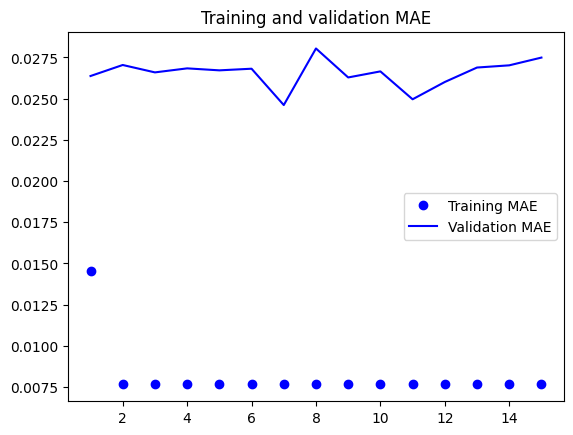

In [12]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

rnn

In [ ]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("C:/models/lstm",
   save_best_only=True)
]


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/30


2023-03-27 22:25:26.642265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-27 22:25:26.644252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-27 22:25:26.645633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3355/4078 [=======================>......] - ETA: 1:12 - loss: 5.8409e-04 - mae: 0.0157

In [ ]:
model = keras.models.load_model("C:/models/lstm")

print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

rnn 2

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("C:/models/lstm2",
   save_best_only=True)
]


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
raw_data